In [1]:
# Librerías necesarias
import boto3
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Conecta con Athena
session = boto3.Session(profile_name='profeco', region_name='us-east-1')


#### *Creamos la tabla 'profeco' dentro de la base de datos de 'profeco_db' en Athena.*

In [3]:
# query para crear tabla profeco
query = '''
CREATE EXTERNAL TABLE IF NOT EXISTS `profeco_db`.`profeco` (
  `producto` string,
  `presentacion` string,
  `marca` string,
  `categoria` string,
  `precio` double,
  `fecharegistro` date,
  `cadenacomercial` string,
  `giro` string,
  `nombrecomercial` string,
  `direccion` string,
  `municipio` string,
  `latitud` double,
  `longitud` double
) COMMENT "Tabla historica quien es quien de profeco"
PARTITIONED BY (`estado` string, `anio` int)
ROW FORMAT SERDE 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT 'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION 's3://proyectoprofeco/data/basicos/'
TBLPROPERTIES ('classification' = 'parquet');
'''

In [4]:
# Crea tabla profeco
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

""


In [5]:
# Sincroniza metadatos de tabla particionada
query_MSCK = '''
MSCK REPAIR TABLE profeco_db.profeco
'''

wr.athena.read_sql_query(
    query_MSCK, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

""


# **Parte B**

# De acuerdo a la categoría que te haya tocado obtén (desde 2018 a 2022) la siguiente información. A nuestro equipo le tocó 'básicos'.

<span style="color:blue"> Nota: Al crear la tabla apuntamos únicamente al parquet con categoría básicos </span>

# ¿De qué año a qué año tienen datos de esa categoría?

In [6]:
query1 = '''
SELECT
    'basicos' as categoria,
    anio,
    COUNT(1) as num_registros
FROM profeco_db.profeco
GROUP BY anio
ORDER BY anio
'''

wr.athena.read_sql_query(
    query1, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,categoria,anio,num_registros
0,basicos,2018,8804761
1,basicos,2019,7398860
2,basicos,2020,6170515
3,basicos,2021,6919490
4,basicos,2022,7945110
5,basicos,2023,7742108
6,basicos,2024,1986577


#### *Se tienen datos desde el 2018 hasta el 2024.*

# ¿Cuántos registros de fecha hay vacíos?

In [7]:
query2 = '''
SELECT
    COUNT(1) as fechas_vacios
FROM
    profeco_db.profeco
WHERE
    fecharegistro is NULL
'''

wr.athena.read_sql_query(
    query2, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,fechas_vacios
0,0


In [8]:
query2b = '''
SELECT
    DISTINCT fecharegistro
FROM
    profeco_db.profeco
ORDER BY 1
'''

res2 = wr.athena.read_sql_query(
    query2b, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

In [ ]:
#Lo mandamos a un csv para comprobar que no había fechas nulas.
#res2.to_csv('resultado.csv', index=False)

#### *No existen registros de fechas vacíos.*

# ¿Cuántos registros tienes por año?

In [9]:
query3 = '''
SELECT
    anio,
    count(1) as total_registros
FROM
    profeco_db.profeco
GROUP BY
    anio
ORDER BY
    anio
'''

wr.athena.read_sql_query(
    query3, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,anio,total_registros
0,2018,8804761
1,2019,7398860
2,2020,6170515
3,2021,6919490
4,2022,7945110
5,2023,7742108
6,2024,1986577


#### *El número de registros oscila entre 6 y 9 millones entre 2018 y 2023. Los registros en 2024 son menores porque por el momento solo se tienen 3 meses registrados.*

# ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?

In [10]:
query4 = '''
SELECT
    anio,
    'basicos' as catalogo,
    MIN(precio) AS precio_minimo,
    MAX(precio) AS precio_maximo,
    AVG(precio) AS precio_promedio,
    STDDEV_POP(precio) AS desviacion_estandar,
    APPROX_PERCENTILE(precio, 0.5) AS precio_mediano,
    APPROX_PERCENTILE(precio, 0.25) AS cuantil_25,
    APPROX_PERCENTILE(precio, 0.75) AS cuantil_75
FROM profeco_db.profeco
GROUP BY anio
ORDER BY anio
'''

wr.athena.read_sql_query(
    query4, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,anio,catalogo,precio_minimo,precio_maximo,precio_promedio,desviacion_estandar,precio_mediano,cuantil_25,cuantil_75
0,2018,basicos,1.0,899.0,46.443535,48.804694,30.047483,16.865155,54.988119
1,2019,basicos,1.0,659.9,47.617151,50.498666,30.468758,17.032678,56.445161
2,2020,basicos,1.0,844.9,51.223467,53.187702,33.067239,18.786596,61.687943
3,2021,basicos,1.0,798.9,53.788488,56.237455,34.457357,19.905828,63.542072
4,2022,basicos,1.0,690.0,59.716877,62.383832,38.473111,22.823100,71.420598
5,2023,basicos,1.2,869.0,65.701468,68.851437,42.228160,24.552587,79.321439
6,2024,basicos,1.3,799.0,66.911763,70.214765,42.759419,25.282505,80.757651


#### *En la tabla anterior, se muestran las estadísticas para el catálogo de 'básicos' por año.*

# ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dio lo mismo en Spark?

In [11]:
query5 = '''
WITH ranked_brands AS (
    SELECT
        estado,
        marca,
        precio,
        ROW_NUMBER() OVER (PARTITION BY estado, marca ORDER BY precio DESC) AS rank
    FROM
        profeco_db.profeco
),
ranked AS (
    SELECT
        estado,
        marca,
        precio,
        rank,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio DESC) AS rank2
    FROM
        ranked_brands
    WHERE
        rank = 1
),
ranked_states AS (
    SELECT
        estado,
        marca,
        precio,
        rank2
    FROM
        ranked
    WHERE
        rank2 <= 5
)
SELECT
    * 
FROM
    ranked_states;
'''

wr.athena.read_sql_query(
    query5, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,estado,marca,precio,rank2
0,aguascalientes,saba,609.00,1
1,aguascalientes,sin_marca,570.00,2
2,aguascalientes,diva_cup,559.48,3
3,aguascalientes,cazadores,505.00,4
4,aguascalientes,jose_cuervo,485.00,5
...,...,...,...,...
155,baja_california_sur,diva_cup,690.00,1
156,baja_california_sur,sin_marca,685.00,2
157,baja_california_sur,saba,580.00,3
158,baja_california_sur,huggies,495.00,4


#### *Destaca que, en general, las marcas en el top 5 con mayores precios son de bebidas alcohólicas, entre otras cosas. Sin embargo, la marca con el mayor precio (excluyendo 'sin marca') coincide con la información obtenida en Spark, donde la marca con mayor precio era diva_cup con un precio de 869 pesos en Guanajuato.*

# ¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dio lo mismo en Spark?

In [12]:
query6 = '''
SELECT 
    marca,
    min(precio) AS min_precio
FROM
    profeco_db.profeco
WHERE
    estado = 'ciudad_de_mexico'
GROUP BY
    marca
ORDER BY 
    2 ASC
LIMIT 5
'''

wr.athena.read_sql_query(
    query6, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,marca,min_precio
0,sin_marca,1.0
1,clight,1.2
2,frutimax,1.5
3,fud,2.0
4,zuko,2.0


#### *La marca con menor precio en la CDMX coincide con lo obtenido en Spark, excluyendo los productos sin marca. En ambos casos tienen un precio de 1.20 pesos.*

# ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dio lo mismo en Spark?

In [13]:
query7 = '''
SELECT
    marca,
    COUNT(*) AS total_observaciones
FROM
    profeco_db.profeco
GROUP BY
    marca
ORDER BY
    total_observaciones DESC
LIMIT 5
'''

wr.athena.read_sql_query(
    query7, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,marca,total_observaciones
0,sin_marca,2763012
1,la_costena,1311513
2,fud,1205957
3,coca_cola,1195553
4,lala,1114597


#### *La marca con mayores observaciones coincide con lo obtenido en Spark, al ser La Costeña con 1,311,513 observaciones (exactamente igual a lo obtenido en Spark).*

# Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.

In [14]:
query8 = '''
WITH ranked_brands AS (
    SELECT
        anio,
        marca,
        COUNT(*) AS total_observaciones,
        ROW_NUMBER() OVER (PARTITION BY anio ORDER BY COUNT(*) DESC) AS rank
    FROM
        profeco_db.profeco
    GROUP BY
        anio, marca
)
SELECT
    anio,
    marca,
    total_observaciones
FROM
    ranked_brands
WHERE
    rank <= 5
ORDER BY anio
'''

tabla8 = wr.athena.read_sql_query(
    query8, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

tabla8

,anio,marca,total_observaciones
0,2018,sin_marca,529969
1,2018,la_costena,259872
2,2018,fud,246526
3,2018,lala,225691
4,2018,alpura,218117
5,2019,sin_marca,433598
6,2019,la_costena,204037
7,2019,coca_cola,194242
8,2019,fud,192723
9,2019,alpura,181257


#### *El top 5 de marcas con mayor número de observaciones por año no cambia mucho en el tiempo. Siendo las principales: La Costeña, Fud, Coca-Cola, Alpura,  y Lala.* 

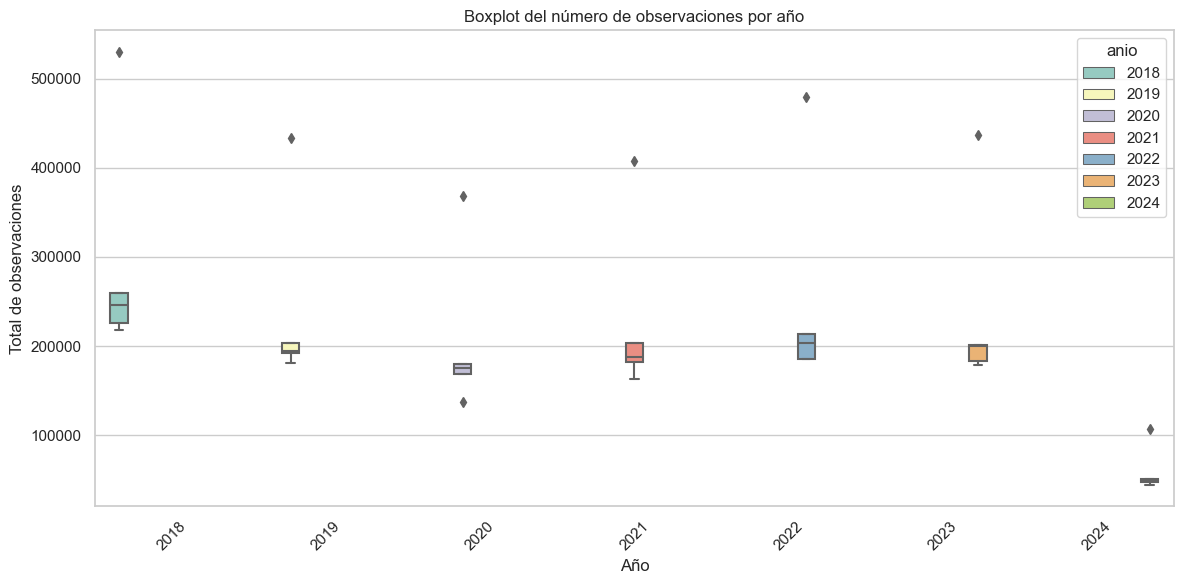

In [15]:
#boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=tabla8, x='anio', y='total_observaciones', hue='anio', palette='Set3')
plt.title('Boxplot del número de observaciones por año')
plt.xlabel('Año')
plt.ylabel('Total de observaciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Nota**: ¡¡¡Lo principal aqui es tu código de SQL para construir las tablas!!! Eso es lo que voy a calificar. R y Pandas, están ahí para que puedas gráficar y hacer tus tablas bonitas en el reporte, OJO no para sacar las estadísticas.

## **Hint**: Guarda tus consultas en archivos que puedas guardar en S3 y luego leer desde Pandas o RStudio, para hacer tus gráficas o cuadros compartivos.